# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

Загрузка данных

In [2]:
df = pd.read_csv('autos.csv')

In [5]:
df = df.drop('Unnamed: 0', axis=1)

Осмотр данных

In [7]:
df.shape

(354369, 16)

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.sample()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
218307,2016-03-30 22:56:00,16800,sedan,2011,auto,151,other,80000,6,hybrid,opel,no,2016-03-30 00:00:00,0,25764,2016-04-05 17:45:29


In [5]:
df.tail()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Есть пропуски в нескольких категориальных признаках. Заполняю их значением `unknown`

In [9]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df['Gearbox'] = df['Gearbox'].fillna('unknown')
df['Model'] = df['Model'].fillna('unknown')
df['FuelType'] = df['FuelType'].fillna('unknown')
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')

Создание отдельных признаков месяца и дня для признаков с датами

In [10]:
date_columns = ['DateCrawled', 'DateCreated', 'LastSeen']

In [11]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
df['DateCreated'] = pd.to_datetime(df['DateCreated'])
df['LastSeen'] = pd.to_datetime(df['LastSeen'])

In [12]:
for column in date_columns:
    df[f'{column}_month'] = pd.DatetimeIndex(df[f'{column}']).month
    df[f'{column}_day'] = pd.DatetimeIndex(df[f'{column}']).day

In [13]:
df = df.drop(date_columns, axis=1)

`Label encoding` категориальных признаков

In [14]:
cat_columns = list(df.select_dtypes(include='object').columns)

In [15]:
le = LabelEncoder()
for column in cat_columns:
    le.fit(df[column].astype('str'))
    df[column] = le.transform(df[column].astype('str'))

Создаю переменные для признаков и целевого признака

In [16]:
X = df.drop('Price', axis=1)
y = df['Price']

Так как у нас нет скрытой тестовой выборки, то с помощью `train_test_split` разбиваю данные на две части - обучающую и тестовую выборки в соотношении 70:30 соответственно.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Обучение моделей

Для поиска оптимальной комбинации гиперпараметров для `LGBMRegressor` использую `GridSearchCV` с кросс-валидацией на трёх подвыборках. 

In [21]:
kf = KFold(3, shuffle=True, random_state=42)

In [22]:
param_grid = {
    'n_estimators': [500], 
    'learning_rate': [0.25],
    'max_depth': [6, 8, 10],
    'num_leaves': [50, 100, 200]
}

In [23]:
grid = GridSearchCV(lgb.LGBMRegressor(random_state=42), 
                    param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1, refit=False) 
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [500], 'learning_rate': [0.25], 'max_depth': [6, 8, 10], 'num_leaves': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

#### Линейная регрессия

In [24]:
lr = LinearRegression()

In [25]:
%%time
lr.fit(X_train, y_train)

Wall time: 223 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [26]:
%%time
test_prediction_lr = lr.predict(X_test)

Wall time: 26.2 ms


In [28]:
lr.fit(X_train, y_train)
test_prediction_lr = lr.predict(X_test)

In [29]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, test_prediction_lr)))

RMSE: 3608.6359500924364


#### Случайный лес

Для `RandomForestRegressor` поиск будет осуществляться по гиперпараметрам `max_depth`, `min_samples_split`. Создаю переменную `tree_params` c различными вариантами значений указанных гиперпараметров.

In [30]:
tree_params = {'max_depth': [4, 6, 8, 10],
               'min_samples_split': [2, 5, 8, 10]}

In [31]:
grid_rfr = GridSearchCV(RandomForestRegressor(random_state=42), 
                        tree_params, refit=False, cv=kf, n_jobs=-1, scoring='neg_mean_squared_error') 
grid_rfr.fit(X_train, y_train)
grid_rfr.best_params_

{'max_depth': 10, 'min_samples_split': 10}

# 3. Анализ моделей

Создаю датафрейм с результами случайного леса с различными гиперпараметрами

In [32]:
fit_time = []
score_time = []
max_depth = []
min_samples_split = []
score = []
for i in range(len(grid_rfr.cv_results_['mean_fit_time'])):
    fit_time.append(grid_rfr.cv_results_['mean_fit_time'][i])
    score_time.append(grid_rfr.cv_results_['mean_score_time'][i])
    max_depth.append(grid_rfr.cv_results_['param_max_depth'][i])
    min_samples_split.append(grid_rfr.cv_results_['param_min_samples_split'][i])
    score.append(grid_rfr.cv_results_['mean_test_score'][i])

In [33]:
grid_results_rfr = pd.DataFrame(list(zip(fit_time, score_time, max_depth, min_samples_split, score)), 
               columns =['fit_time', 'score_time', 'max_depth', 'min_samples_split', 'score'])

Перевожу MSE в RMSE

In [34]:
grid_results_rfr['score'] = (-grid_results_rfr['score']) ** 0.5

In [35]:
grid_results_rfr.sort_values('score')

,fit_time,score_time,max_depth,min_samples_split,score
15,11.519700,0.130179,10,10,2036.703950
12,11.379596,0.161422,10,2,2037.154883
14,11.726310,0.156212,10,8,2037.263496
13,11.651837,0.161420,10,5,2037.354844
9,9.446307,0.114556,8,5,2164.552561
11,9.789077,0.140592,8,10,2164.590373
8,9.673654,0.109347,8,2,2164.616656
10,9.441572,0.108268,8,8,2164.631059
4,8.058274,0.078107,6,2,2363.538453
5,7.641915,0.107950,6,5,2363.538453


Визуализация

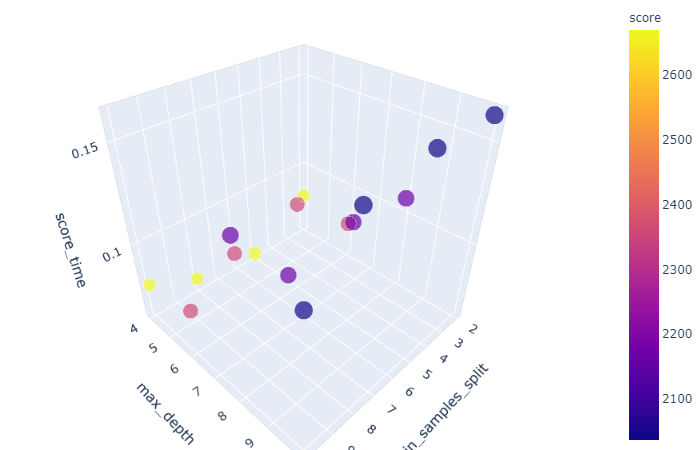

In [36]:
fig = px.scatter_3d(grid_results_rfr, x='min_samples_split', y='max_depth', z='score_time',
              color='score', size='fit_time', size_max=30, opacity=0.7)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show('png')

Создаю датафрейм с результами LGBMRegressor с различными гиперпараметрами

In [37]:
fit_time = []
score_time = []
max_depth = []
num_leaves = []
score = []
for i in range(len(grid.cv_results_['mean_fit_time'])):
    fit_time.append(grid.cv_results_['mean_fit_time'][i])
    score_time.append(grid.cv_results_['mean_score_time'][i])
    max_depth.append(grid.cv_results_['param_max_depth'][i])
    num_leaves.append(grid.cv_results_['param_num_leaves'][i])
    score.append(grid.cv_results_['mean_test_score'][i])

In [38]:
grid_results = pd.DataFrame(list(zip(fit_time, score_time, max_depth, num_leaves, score)), 
               columns =['fit_time', 'score_time', 'max_depth', 'num_leaves', 'score'])

Перевожу MSE в RMSE

In [39]:
grid_results['score'] = (-grid_results['score']) ** 0.5

In [40]:
grid_results.sort_values('score')

,fit_time,score_time,max_depth,num_leaves,score
3,13.853491,11.053880,8,50,1712.051237
6,14.190546,6.360118,10,50,1712.584242
0,14.493807,15.582268,6,50,1715.510785
4,20.830207,20.586059,8,100,1716.161690
1,14.928593,15.559561,6,100,1717.003041
2,14.955699,17.138023,6,200,1717.003041
7,18.458144,11.462250,10,100,1722.676899
5,23.912368,27.489903,8,200,1722.984500
8,26.155467,22.530135,10,200,1729.062709


Визуализация

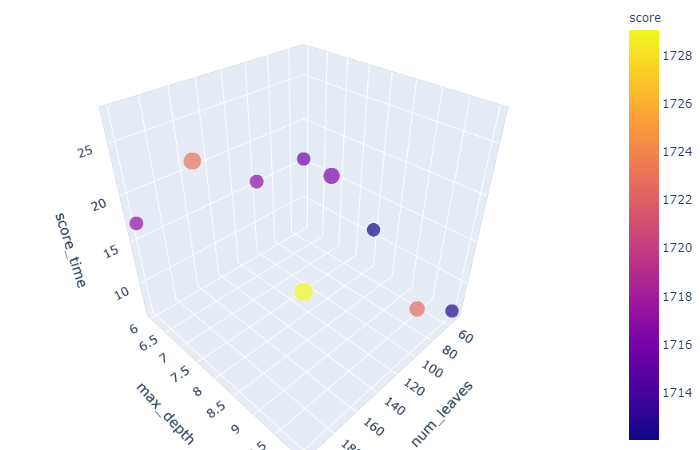

In [41]:
fig = px.scatter_3d(grid_results, x='num_leaves', y='max_depth', z='score_time',
              color='score', size='fit_time', size_max=30, opacity=0.7)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show('png')

## Вывод:
- Линейная регрессия с результатом `0.223` секунды показала себя самой быстрой моделью по скорости обучения. Лучший результат случайного леса - `5.31` секунды. Бустинг обучается значительно дольше - `14` секунд. При этом качество предсказаний по метрике RMSE расположились в обратном порядке - 3608, 2030, 1712 соответственно. 
- Для случайного леса наблюдается линейная зависимость качества и времени обучения от гиперпараметра глубины дерева.
- Исходя из требований к качеству и скорости предсказания, а также времени обучения, оптимальным сочетанием гиперпараметров будет - `n_estimators=500`, `learning_rate=0.25`, `max_depth=8`, `num_leaves=50` у модели `LGBMRegressor`

Расчет RMSE на тестовой выборке для `LGBMRegressor` с наиболее оптимальными гиперпараметрами

In [43]:
model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.25, max_depth=8, num_leaves=50)
model.fit(X_train, y_train)
test_prediction = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,test_prediction)))

1695.2267209505624
